# Outline

**Purpose**: The purpose of this script is to evaluate the performance of different response coding models in capturing the underlying data generated by different processes.

**method**: To achieve this objective, we carefully selected four models of response coding with a range of parameter values, similar to the process used in parameter recovery. Data is then simulated from each of these models, and the simulated data is fit using all four models to assess how well each model captures the data generated by the same model versus different models. This allows us to compare the effectiveness of each response coding model in matching the simulated data generated by a specific model to the correct model versus other models.

In [1]:
#system
import sys
import os
#function
import utils
#variable
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
from patsy import dmatrix
#plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import ptitprince as pt
# model
import kabuki
import hddm
from hddm import HDDMRegressor
# stats
import bambi as bmb
# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
print(f'The version of python is {sys.version}')
print(f'The version of numpy is {np.__version__}')
print(f'The version of pandas is {pd.__version__}')
print(f'The version of matplotlib is {matplotlib.__version__}')
print(f'The version of seaborn is {sns.__version__}')
print(f'The version of arviz is {az.__version__}')
print(f'The version of hddm is {hddm.__version__}')
print(f'The version of kabuki is {kabuki.__version__}')
print(f'The version of bambi is {bmb.__version__}')

The version of python is 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
The version of numpy is 1.20.3
The version of pandas is 1.3.5
The version of matplotlib is 3.3.4
The version of seaborn is 0.11.2
The version of arviz is 0.12.0
The version of hddm is 0.8.0
The version of kabuki is 0.6.4
The version of bambi is 0.8.0


In [3]:
# set the figure theme
sns.set_theme(style="whitegrid")
# set random seed
np.random.seed(123)

## Main function

To improve the readability and simplify the code, we have packaged some repetitive code into functions. These functions are designed to perform specific tasks and can be called whenever needed. This makes the code more modular and easier to maintain. 

By using functions, we can avoid repeating the same code multiple times and reduce the risk of errors. Additionally, we can reuse the same function in different parts of the code, making it more efficient and saving time. 

Overall, packaging repetitive code into functions is a best practice that enhances the clarity and usability of the code.

In [50]:
def gen_subj_params(params, model, n_subjs, exparam, bias = True, dc = 0):
    """Generate individual parameters for each subjects.
        
        :Arguments:
            params:dict
                Parameters to use for data generate. 
            n_subjs:integer
                How many subjs to generate params. 
            exparam: string
                The param is condition truth which need not to add noise for subjects.
            bias:bool
                If stim coding, bias is true.
    """
    group_params_cond = pd.DataFrame([])
    for cond,param in params.items():
        group_params = pd.DataFrame([])
        for subj_idx in range(n_subjs):
            subj_params= pd.DataFrame([])
            for stim in [0, 1]:
                if stim == 0:
                    subj_params_stim = kabuki.generate._add_noise(params={cond:param}, 
                                        noise=OrderedDict([('v', 0.2),
                                                       ('a', 0.2),
                                                       ('t', 0.1),
                                                       ('sv', 0.1),
                                                        ('z',0.1),
                                                       ('v', 0.1)]), 
                                        share_noise=('v','a','t','st','sz','sv','z'),
                                        check_valid_func=hddm.utils.check_params_valid,
                                        bounds={'a': (0, np.inf),
                                                  'z': (0, 1),
                                                  't': (0, np.inf), 
                                                  'st': (0, np.inf),
                                                  'sv': (0, np.inf),
                                                  'sz': (0, 1)},
                                        exclude_params={exparam,'st', 'sv', 'sz'})
                    subj_params_stim = pd.DataFrame(subj_params_stim).T
                    if (bias == True) and (exparam == 'dc'):
                        subj_params_stim['v'] = subj_params_stim['v']+dc
                else:
                    if (bias == True ) and (exparam =='v'):
                        subj_params_stim['v'] = - subj_params_stim['v']
                    elif (bias == True ) and (exparam =='z'):
                        subj_params_stim['z'] = 1 - subj_params_stim['z']
                    elif (bias == True ) and (exparam =='dc'):
                        subj_params_stim['v'] = 2*dc - subj_params_stim['v']
                    elif bias == False:
                        subj_params_stim = subj_params_stim
                subj_params_tmp = subj_params_stim
                subj_params_tmp = subj_params_tmp.reset_index(drop=True)
                subj_params_tmp['condition'] = cond
                subj_params_tmp['subj_idx'] = subj_idx
                subj_params_tmp['stim'] = stim
                subj_params = pd.concat((subj_params,subj_params_tmp),ignore_index=True)
            group_params =  pd.concat((group_params, subj_params), ignore_index=True)
        group_params_cond = pd.concat((group_params_cond, group_params), ignore_index=True)
        group_params_cond.to_csv(f'temp/params_{model}.csv', index=False)
    return group_params_cond

In [51]:
def gen_rt_choices(params, model, n_trials):
    """Returns a DataFrame of randomly simulated RTs from the DDM.
    
        :Arguments:
            params : dataframe
                Parameter of all subjects.
            n_trials:
                How many trials for each condition.
    """
    data = pd.DataFrame([])
    for subj_idx in np.unique(params['subj_idx']):
        data_subj = pd.DataFrame([])
        for cond in np.unique(params['condition']):
            data_cond = pd.DataFrame([])
            for stim in [0,1]:
                param = params.loc[(params['condition'] ==cond)&\
                                   (params['subj_idx'] ==subj_idx)&
                                   (params['stim'] == stim),\
                                   ['sv','sz','st','z','v','t','a']]\
                                    .to_dict(orient='record')[0]
                data_cond_stim = hddm.generate.gen_rts(size=n_trials,
                                                        range_=(-6, 6),
                                                        dt=1e-3,
                                                        intra_sv=1.0,
                                                        structured=True,
                                                        subj_idx=None,
                                                        method="cdf",
                                                        **param)
                data_cond_stim['stim']=stim
                data_cond = pd.concat((data_cond,data_cond_stim))
            data_cond['condition'] = cond
            data_subj = pd.concat([data_subj, data_cond])
        data_subj['subj_idx'] = subj_idx
        data = pd.concat([data, data_subj])
        data = data.reset_index(drop=True)
        data.to_csv(f'temp/data_{model}.csv', index=False)
    return data

In [52]:
def ms1(df, model, condition, samples=100, burn = 10, thin=2):
    """Instantiate a regression model.
    
    :Arguments:
        df:pandas.DataFrame                        
            data containing 'rt' and 'response' column and any
            covariates you might want to use.
        condition:The value in range to observe.
        
            
    
    """
    dbname = f'temp/mres1_{condition}.db'
    
    df = df.loc[df['condition'] == condition]
    m = hddm.HDDMRegressor(df, 
                           {'v~1','z~1','a~1','t~1'},
                           include=['z'],
                           group_only_regressors=False,
                           keep_regressor_trace=True,)
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['condition']=condition
    tc.to_csv(f'temp/mres1_{model}_{condition}.csv',index=False)

    return m

#
def ms2(df, model, condition, samples=100, burn = 10, thin=2):
    dbname = f'temp/mres2_{condition}.db'
    
    df = df.loc[df['condition'] == condition]
    
    def z_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stim.loc[x.index]},return_type='dataframe')))
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip

    m = hddm.HDDMRegressor(df,
                       ['v~1',{'model':'z~1','link_func':z_link_func},'a~1','t~1'],
                       include=['z'],
                       group_only_regressors=False,
                       keep_regressor_trace=True,)
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['condition']=condition
    tc.to_csv(f'temp/mres2_{model}_{condition}.csv',index=False)

    return m
#
def ms3(df, model, condition, samples=100, burn = 10, thin=2):
    dbname = f'temp/mres3_{condition}.db'
    
    df = df.loc[df['condition'] == condition]

    def v_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stim.loc[x.index]},return_type='dataframe'))
        )
        v_flip = x.to_frame()
        v_flip[stim == 1] *= -1
        return v_flip
    
    m = hddm.HDDMRegressor(df, 
                       ['z~1',{'model':'v~1','link_func':v_link_func},'a~1','t~1'],
                       include=['z'],
                       group_only_regressors=False,
                       keep_regressor_trace=True,)
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['condition']=condition
    tc.to_csv(f'temp/mres3_{model}_{condition}.csv',index=False)
    return m

#
def ms4(df, model, condition, samples=100, burn = 10, thin=2):
    dbname = f'temp/mres3_{condition}.db'
    
    df = df.loc[df['condition'] == condition]
    
    df.stim = np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                              {'s': df.stim.loc[df.rt.index]},return_type='dataframe'))
    
    def v_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                                  {'s': df.stim.loc[x.index]},return_type='dataframe')))
        return x.to_frame()*stim
    
    m = hddm.HDDMRegressor(df, 
                       ['z~1',{'model':'v~1+stim','link_func':v_link_func},'a~1','t~1'],
                       include=['z'],
                       group_only_regressors=False,
                       keep_regressor_trace=True,)
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['condition']=condition
    tc.to_csv(f'temp/mres4_{model}_{condition}.csv',index=False)

    return m

In [53]:
def plot_group_params(traces, cond_dict, param):
    """Plot a figure of scatter comparing simlated values and fiited values.
    
        :Arguments:
            traces: dataframe
                Value of samples of different parameters.
            cond_dict: dict
                Parameter of group condition and its range.
            
    """
    plt.figure(figsize=(10,8)) 
    
    x = list(cond_dict.values())[0]
    if param != 'z':
        y = abs(traces.groupby('condition')[f'{param}_Intercept'].mean())
        yerr = traces.groupby('condition')[f'{param}_Intercept'].std()
    else:                
        traces[f'{param}_Intercept_trans'] = traces[f'{param}_Intercept_trans'].apply(lambda x:1/(1+np.exp(-x)))
        y = abs(traces.groupby('condition')[f'{param}_Intercept_trans'].mean())
        yerr = traces.groupby('condition')[f'{param}_Intercept_trans'].std()
    sns.scatterplot(x=x, 
                    y=y,)
    plt.errorbar(x, y, yerr=yerr, fmt="o")
    plt.plot(np.arange(min(x)-0.5,max(x)+0.5,0.1),
             np.arange(min(x)-0.5,max(x)+0.5,0.1),
            linestyle ="--" )
    plt.xlabel('sim value')
    plt.ylabel('fitted value')

In [54]:
def plot_subj_params(traces, params, include, dc=0):
    if 'dc' in include:
        fig=plt.figure(figsize=(20,5))
        for i,param in enumerate(['v','z','a','t','dc']): 
            plt.subplot(1,5,i+1)
            for sim_value in np.unique(traces['condition']):
                for i_subj in np.unique(params['subj_idx']):
                    if (param == 't') or (param == 'a'):
                        x = params.loc[(params['subj_idx']==i_subj)&(params['condition']==sim_value)&(params['stim']==1),f'{param}']
                        y = traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj.{i_subj}'].mean()
                        yerr = traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj.{i_subj}'].std()
                    elif param == 'dc':
                        x = params.loc[(params['subj_idx']==i_subj)&(params['condition']==sim_value)&(params['stim']==0),'v']
                        y = -traces.loc[traces['condition']==sim_value,f'v_stim_subj.{i_subj}'].mean()
                        yerr = traces.loc[traces['condition']==sim_value,f'v_stim_subj.{i_subj}'].std()
                    elif param =='v':
                        x = params.loc[(params['subj_idx']==i_subj)&(params['condition']==sim_value)&(params['stim']==0),'v']-dc
                        y = abs(traces.loc[traces['condition']==sim_value,f'v_Intercept_subj.{i_subj}'].mean())
                        yerr = traces.loc[traces['condition']==sim_value,f'v_Intercept_subj.{i_subj}'].std()
                    else:
                        x = params.loc[(params['subj_idx']==i_subj)&(params['condition']==sim_value)&(params['stim']==0),f'{param}'] 
                        y = np.mean(1/(1+np.exp(-(traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}']))))
                        yerr = np.std(1/(1+np.exp(-(traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}']))))                 
                    sns.scatterplot(x=x, 
                                    y=y,)
                    plt.errorbar(x, y, yerr=yerr, fmt="o")
                    if param != 'dc':
                        plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),
                                 np.arange(min(x)-0.2,max(x)+0.2,0.1),
                                 linestyle ="--" )
                    else:
                        plt.hlines(dc,
                                   xmin=min(x)-0.2,
                                   xmax=max(x)+0.2)

    else:
        fig=plt.figure(figsize=(10,8))
        for i,param in enumerate(['v','z','a','t']): 
            plt.subplot(2,2,i+1)
            for sim_value in np.unique(traces['condition']):
                for i_subj in np.unique(params['subj_idx']):
                    if param != 'z':
                        x = params.loc[(params['subj_idx']==i_subj)&(params['condition']==sim_value)&(params['stim']==0),f'{param}']
                        y = traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj.{i_subj}'].mean()
                        yerr = traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj.{i_subj}'].std()
                    else:
                        x = params.loc[(params['subj_idx']==i_subj)&(params['condition']==sim_value)&(params['stim']==0),f'{param}'] 
                        y = np.mean(1/(1+np.exp(-(traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}']))))
                        yerr = np.std(1/(1+np.exp(-(traces.loc[traces['condition']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}']))))                
                    sns.scatterplot(x=x, 
                                    y=y,)
                    plt.errorbar(x, y, yerr=yerr, fmt="o")
                    plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),
                             np.arange(min(x)-0.2,max(x)+0.2,0.1),
                             linestyle ="--" )
        plt.legend(labels = np.unique(params['subj_idx']),loc='best')

## M1: accuracy coding

In [55]:
n_subjs=12
n_trials=50
#
cond_dict = {'v':[0.5,1,1.5,2,2.5,3]}
# 
group_params = hddm.generate.gen_rand_params(include=(),cond_dict = cond_dict)[0]
#
subj_params = gen_subj_params(params=group_params, model='m1', n_subjs=n_subjs,exparam = 'v', bias = False)
#
data = gen_rt_choices(params = subj_params, model='m1', n_trials=n_trials)

<ipython-input-51-533e4bf3d1bd>:16: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  param = params.loc[(params['condition'] ==cond)&\


### M1

In [56]:
samples = 10
burn = 1
thin = 1

In [57]:
res = Parallel(n_jobs = 6)(delayed(ms1)(df = data, model = 'm1', condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [39]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres1_{cond}.csv')
    traces= traces.append(trace)

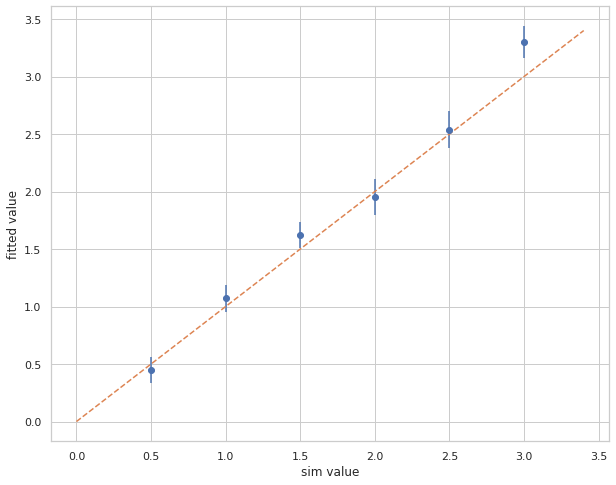

In [14]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

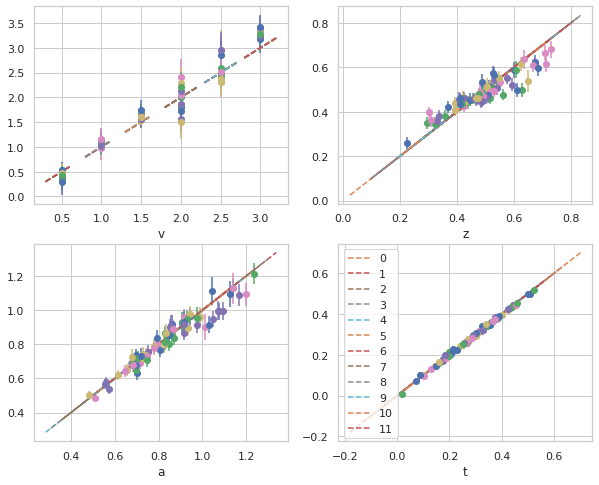

In [15]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M2

In [12]:
res = Parallel(n_jobs = 6)(delayed(ms1)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [13]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres1_{cond}.csv')
    traces= traces.append(trace)

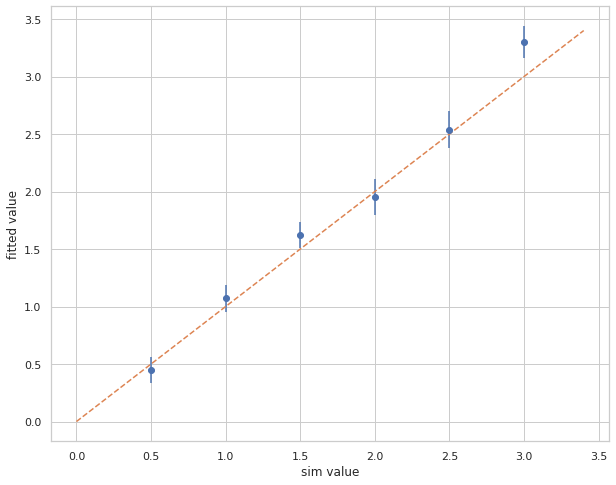

In [14]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

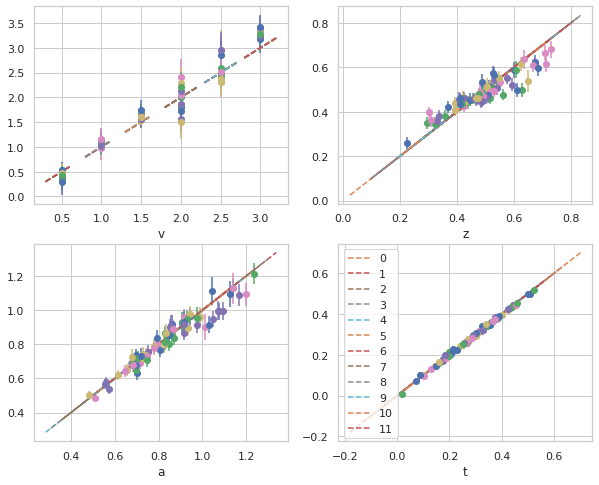

In [15]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M3

In [12]:
res = Parallel(n_jobs = 6)(delayed(ms1)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [13]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres1_{cond}.csv')
    traces= traces.append(trace)

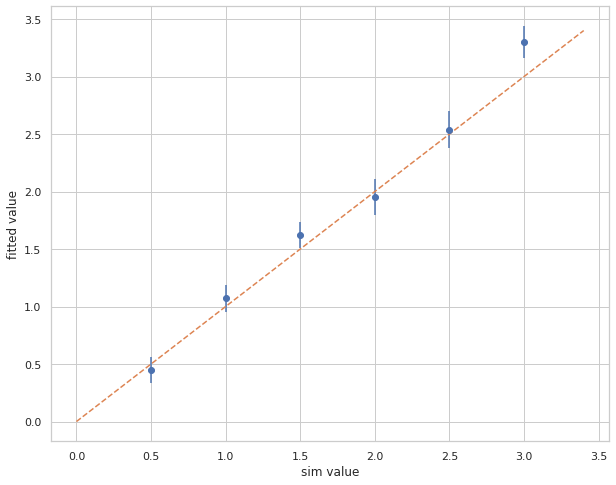

In [14]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

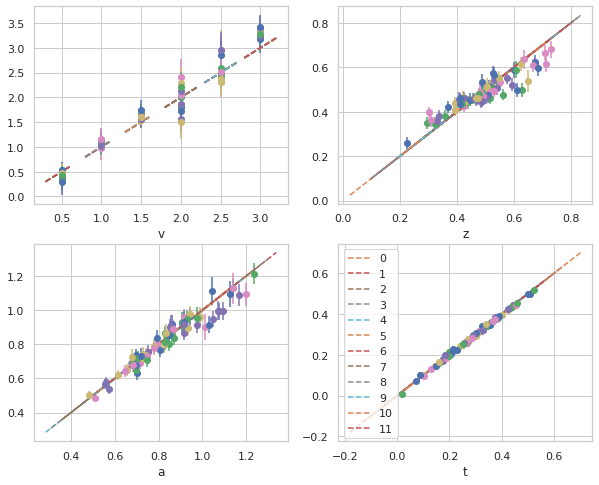

In [15]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M4

In [12]:
res = Parallel(n_jobs = 6)(delayed(ms1)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [13]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres1_{cond}.csv')
    traces= traces.append(trace)

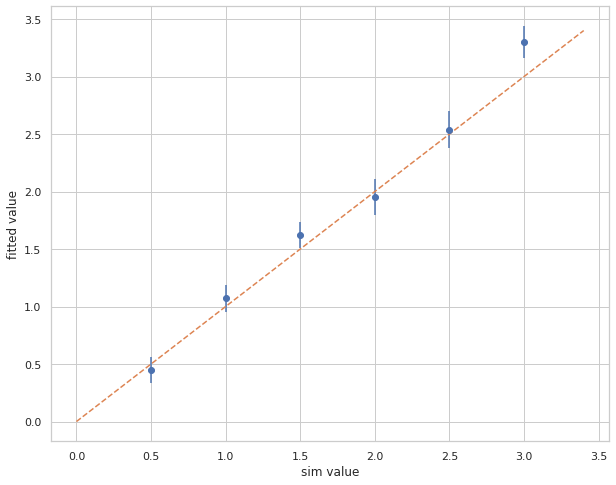

In [14]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

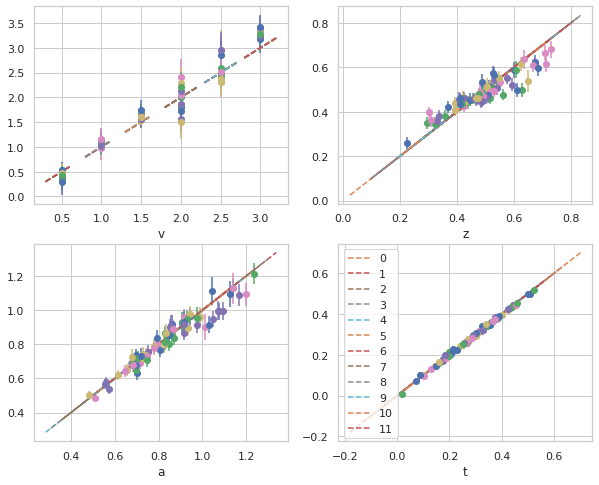

In [15]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

## M2: stim coding, z bias

In [16]:
n_subjs=12
n_trials=50
#
cond_dict = {'z':[0.1,0.3,0.5,0.6,0.7,0.9]}
# 
group_params = hddm.generate.gen_rand_params(include=(),cond_dict = cond_dict)[0]
#
subj_params = gen_subj_params(params=group_params, n_subjs=n_subjs,exparam = 'z', bias = True)
#
data = gen_rt_choices(params = subj_params, n_trials=n_trials)

<ipython-input-5-344263391a5f>:16: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  param = params.loc[(params['condition'] ==cond)&\


### M1

In [17]:
res = Parallel(n_jobs = 6)(delayed(ms2)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [18]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres2_{cond}.csv')
    traces= traces.append(trace)

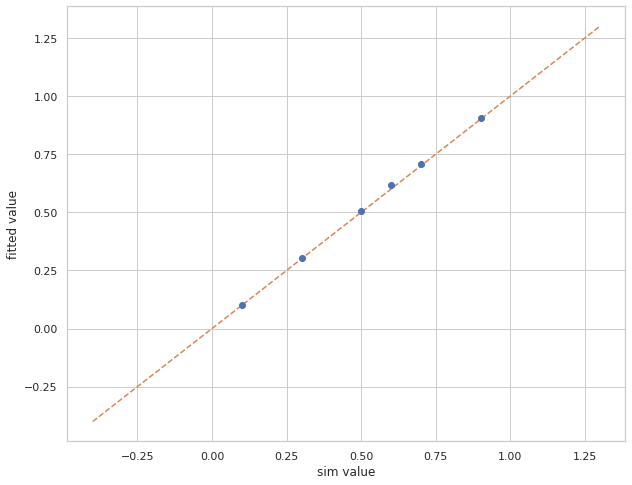

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='z')

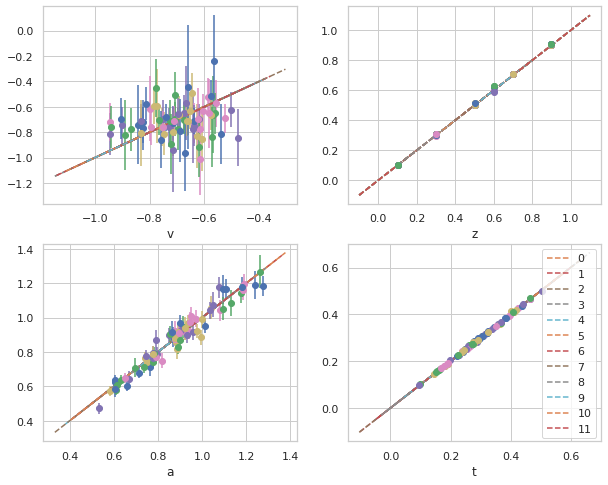

In [20]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M2

In [17]:
res = Parallel(n_jobs = 6)(delayed(ms2)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [18]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres2_{cond}.csv')
    traces= traces.append(trace)

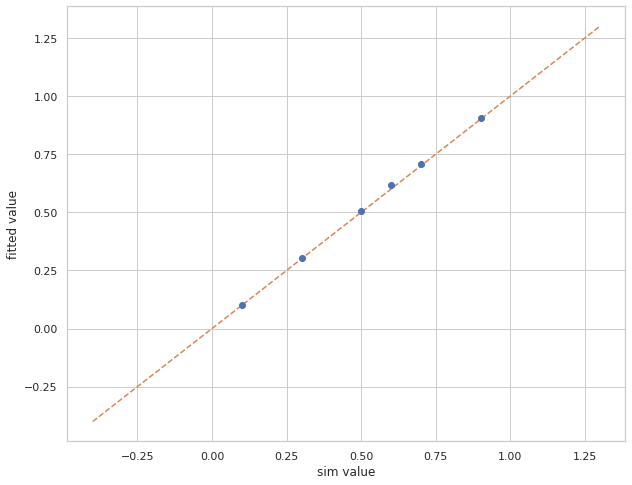

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='z')

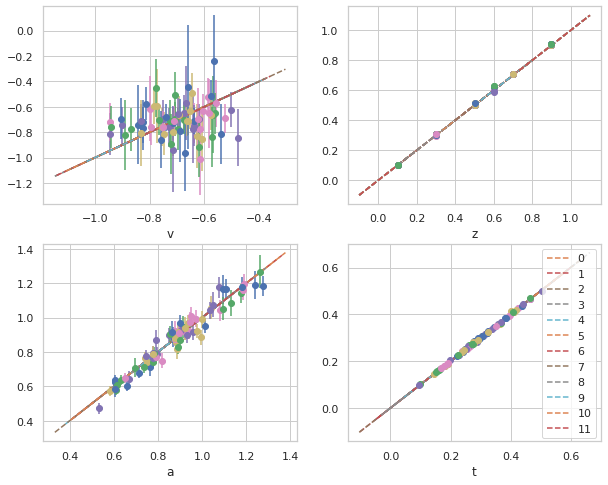

In [20]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M3

In [17]:
res = Parallel(n_jobs = 6)(delayed(ms2)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [18]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres2_{cond}.csv')
    traces= traces.append(trace)

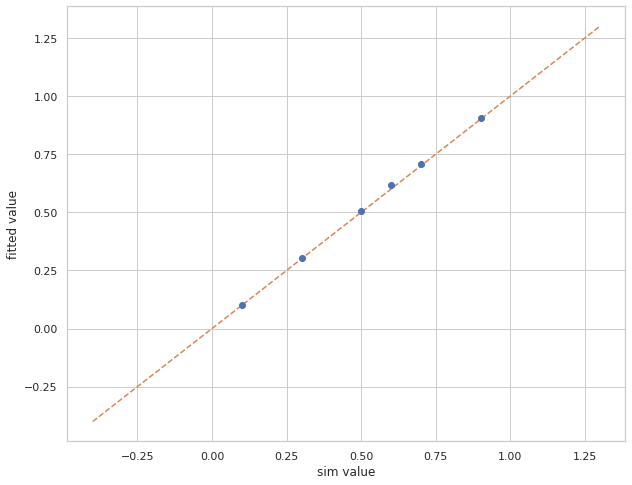

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='z')

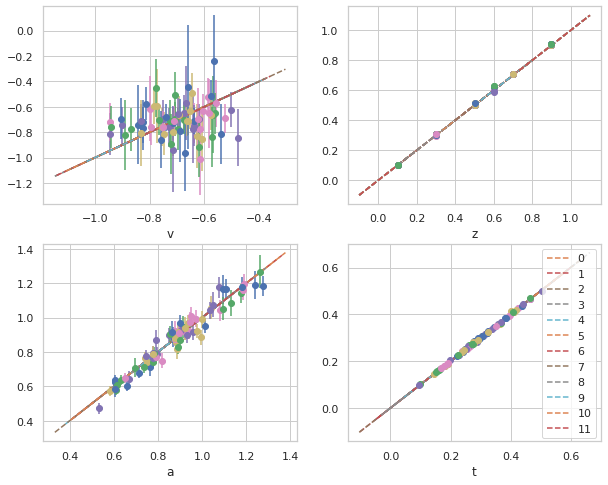

In [20]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M4

In [17]:
res = Parallel(n_jobs = 6)(delayed(ms2)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [18]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres2_{cond}.csv')
    traces= traces.append(trace)

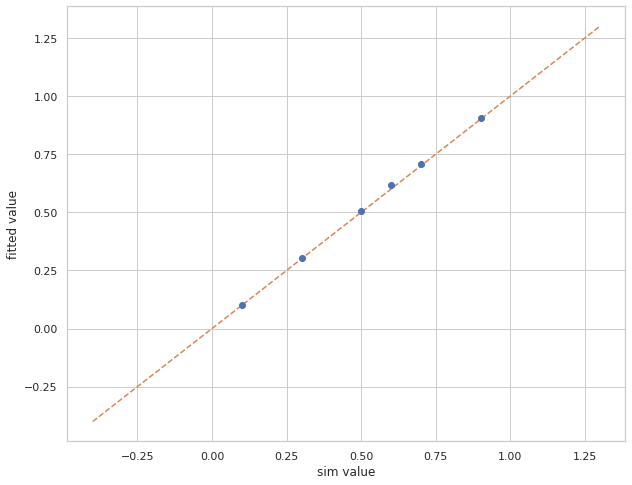

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='z')

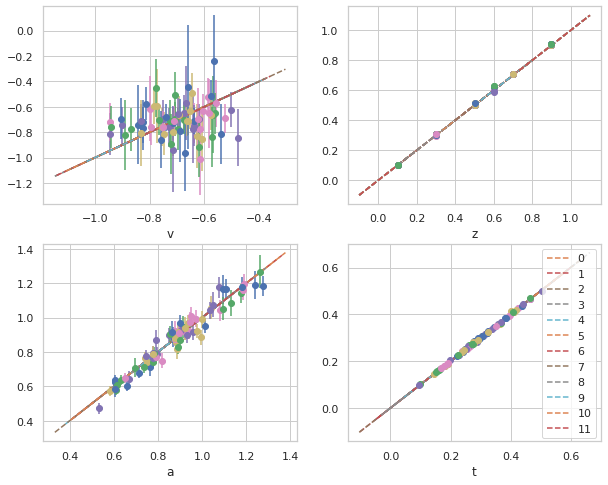

In [20]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

## M3: stim coding, v bias

In [21]:
n_subjs=12
n_trials=50
#
cond_dict = {'v':[0.5,1,1.5,2,2.5,3]}
# 
group_params = hddm.generate.gen_rand_params(include=(),cond_dict = cond_dict)[0]
#
subj_params = gen_subj_params(params=group_params, n_subjs=n_subjs,exparam = 'v', bias = True)
#
data = gen_rt_choices(params = subj_params, n_trials=n_trials)

<ipython-input-5-344263391a5f>:16: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  param = params.loc[(params['condition'] ==cond)&\


### M1

In [22]:
res = Parallel(n_jobs = 6)(delayed(ms3)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [23]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres3_{cond}.csv')
    traces= traces.append(trace)

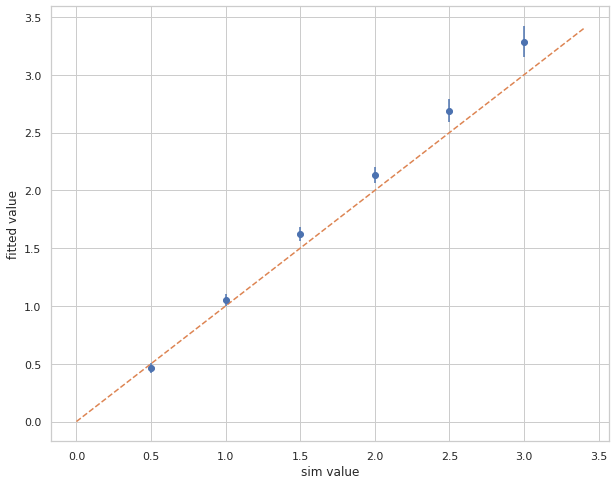

In [24]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

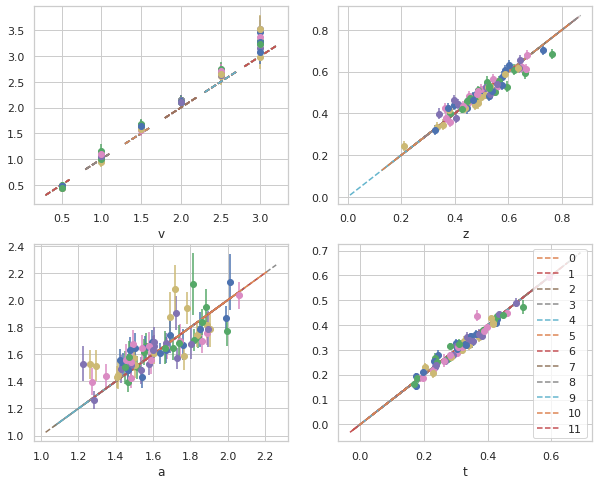

In [25]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M2

In [22]:
res = Parallel(n_jobs = 6)(delayed(ms3)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [23]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres3_{cond}.csv')
    traces= traces.append(trace)

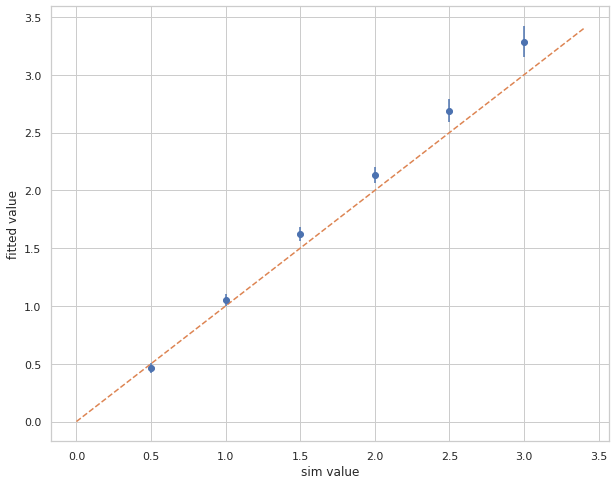

In [24]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

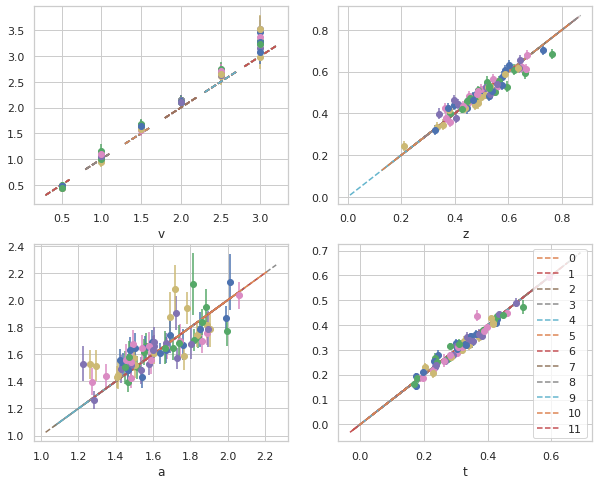

In [25]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M3

In [22]:
res = Parallel(n_jobs = 6)(delayed(ms3)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [23]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres3_{cond}.csv')
    traces= traces.append(trace)

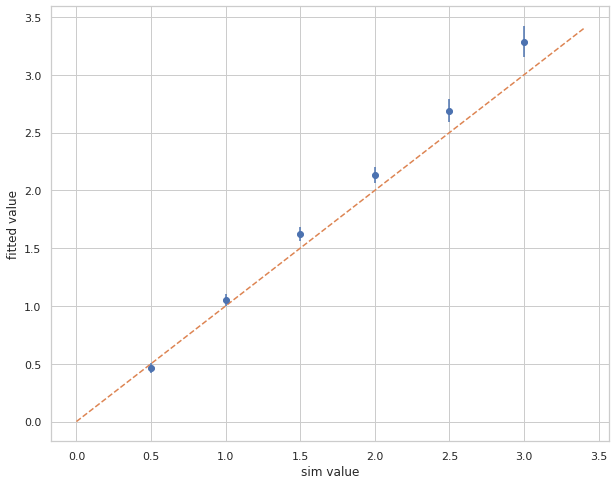

In [24]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

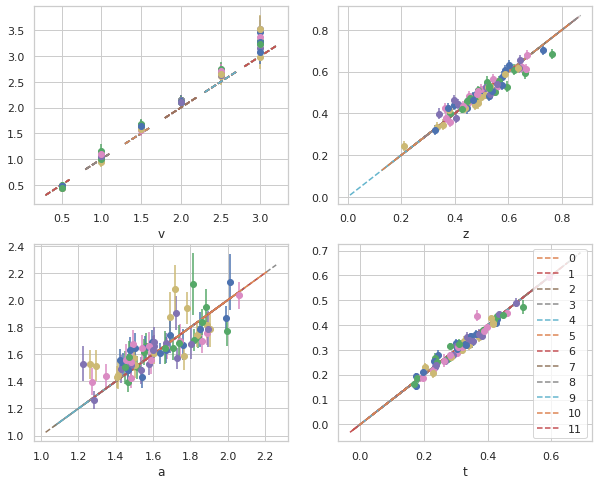

In [25]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

### M4

In [22]:
res = Parallel(n_jobs = 6)(delayed(ms3)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [23]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres3_{cond}.csv')
    traces= traces.append(trace)

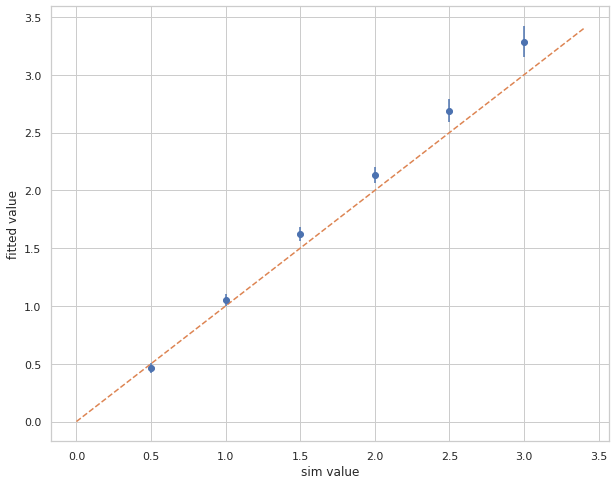

In [24]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

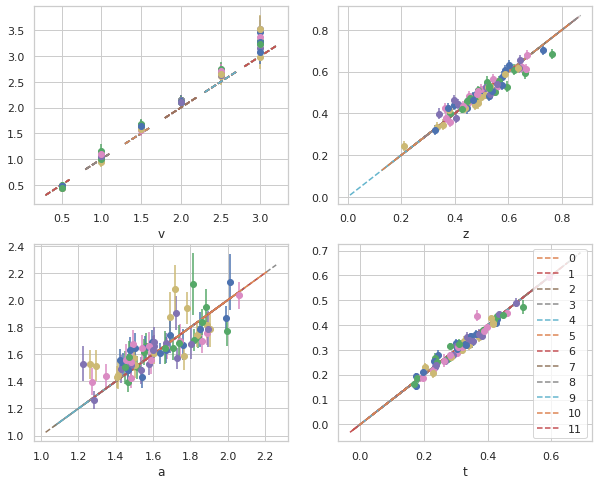

In [25]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t'))

## M4: stim coding, v bias, dc

In [12]:
n_subjs=12
n_trials=50
#
dc = 0.6
#
cond_dict = {'v':[0.5,1,1.5,2,2.5,3]}
# 
group_params = hddm.generate.gen_rand_params(include=(),cond_dict = cond_dict)[0]
#
subj_params = gen_subj_params(params=group_params, n_subjs=n_subjs,exparam = 'dc', bias = True, dc=dc)
#
data = gen_rt_choices(params = subj_params, n_trials=n_trials)

<ipython-input-5-344263391a5f>:16: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  param = params.loc[(params['condition'] ==cond)&\


### M1

In [27]:
res = Parallel(n_jobs = 6)(delayed(ms4)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [13]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres4_{cond}.csv')
    traces= traces.append(trace)

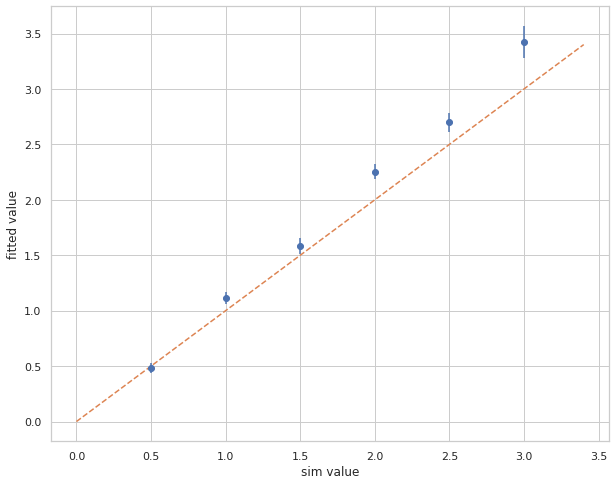

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

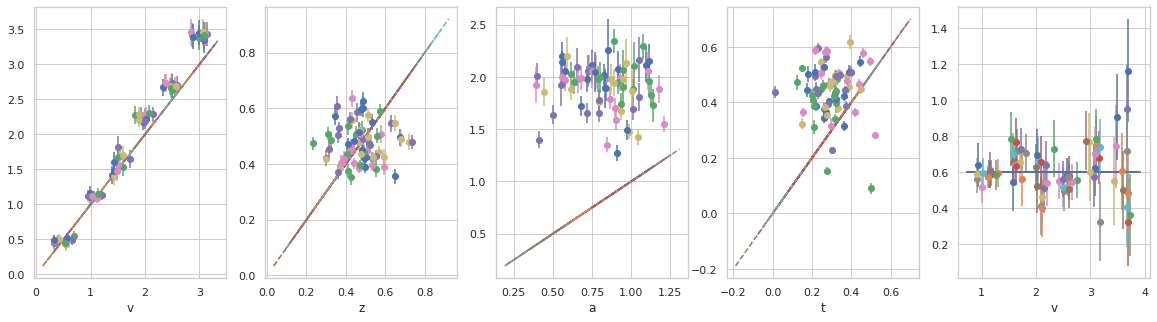

In [33]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t','dc'),dc=dc)

### M2

In [27]:
res = Parallel(n_jobs = 6)(delayed(ms4)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [13]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres4_{cond}.csv')
    traces= traces.append(trace)

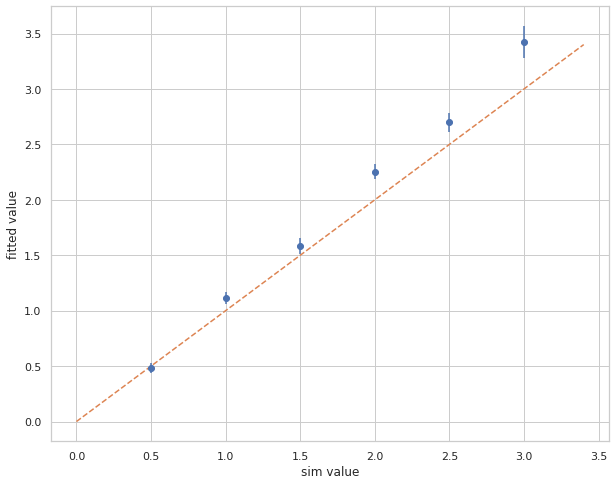

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

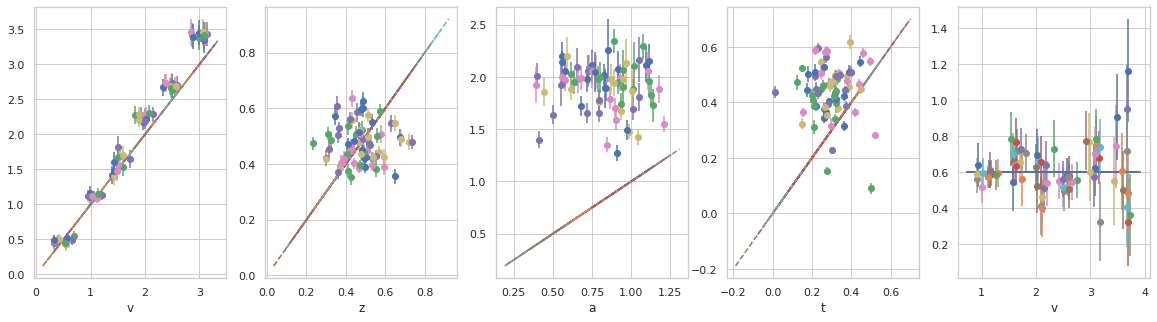

In [33]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t','dc'),dc=dc)

### M3

In [27]:
res = Parallel(n_jobs = 6)(delayed(ms4)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [13]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres4_{cond}.csv')
    traces= traces.append(trace)

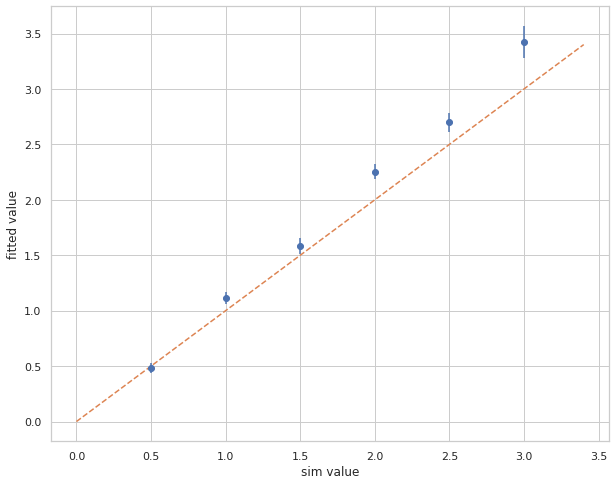

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

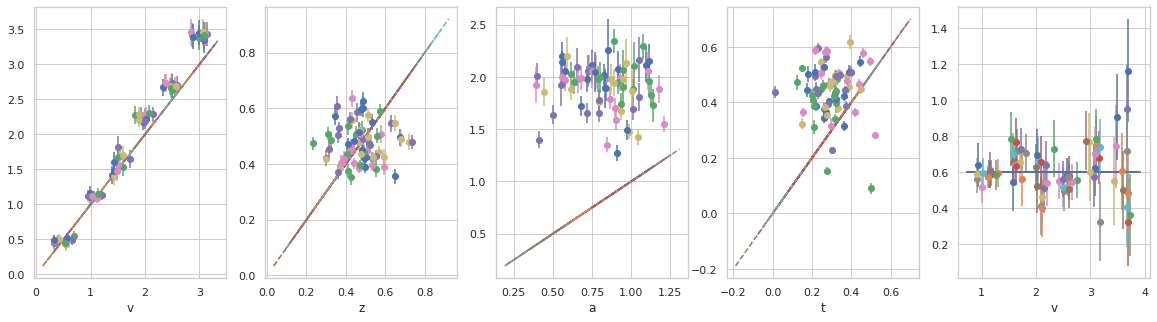

In [33]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t','dc'),dc=dc)

### M4

In [27]:
res = Parallel(n_jobs = 6)(delayed(ms4)(df = data, condition = condition, samples=samples,burn = burn,thin=thin) for condition in np.unique(data['condition']))

In [13]:
traces = pd.DataFrame([])
for cond in np.unique(data['condition']):
    trace = pd.read_csv(f'mres4_{cond}.csv')
    traces= traces.append(trace)

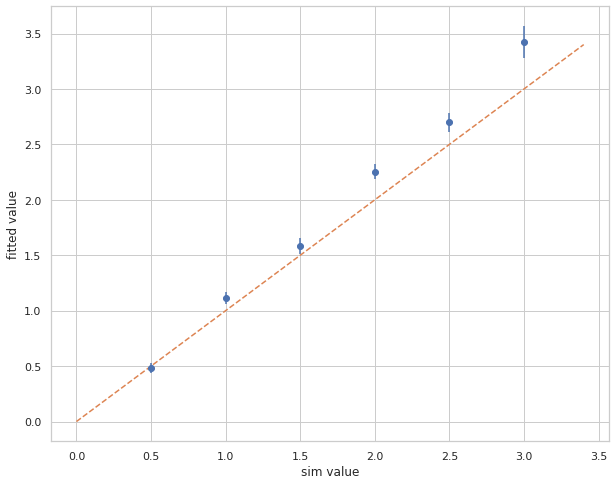

In [19]:
plot_group_params(traces=traces, cond_dict=cond_dict, param='v')

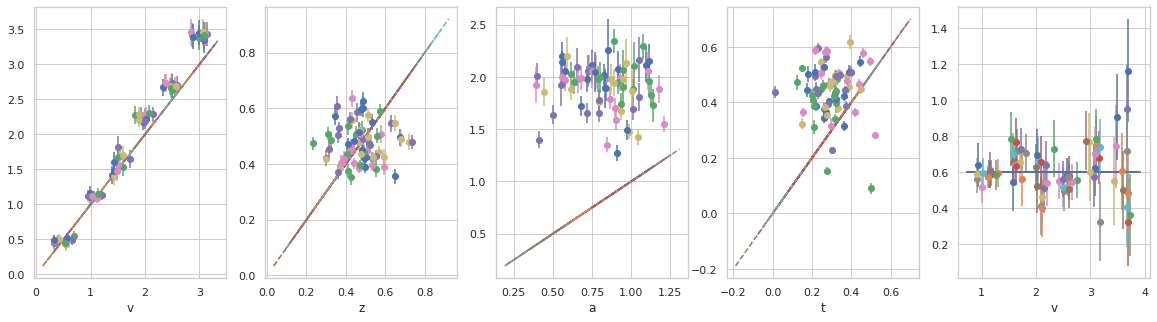

In [33]:
plot_subj_params(traces=traces,params=subj_params,include = ('v','z','a','t','dc'),dc=dc)